# Простейшие нейронные сети на PyTorch


Фрэймворком для обучения нейросеток на нашем курсе будет PyTorch. PyTorch стал очень популярным благодаря интуитивно понятной парадигме программирования нейронных сетей, основанной на динамическом графе. Не так давно PyTorch создал свою экосистему https://pytorch.org/ecosystem/, которая содержит в себе библиотеки, решающие практически всевозможные задачи машинного обучения. 

Чтобы установить библиотеку PyTorch, отправляйтесь в консоль и пропишите 

```
Для Windows без GPU
pip install torch==1.6.0+cpu torchvision==0.7.0+cpu -f https://download.pytorch.org/whl/torch_stable.html

Для Windows c GPU
pip install torch==1.6.0+cu101 torchvision==0.7.0+cu101 -f https://download.pytorch.org/whl/torch_stable.html

Для Linux без GPU
pip install torch==1.6.0+cpu torchvision==0.7.0+cpu -f https://download.pytorch.org/whl/torch_stable.html

Для Linux c GPU
pip install torch==1.6.0+cu101 torchvision==0.7.0+cu101 -f https://download.pytorch.org/whl/torch_stable.html

Для Mac
pip install torch torchvision

pip install pytorch-lightning
```


In [44]:
import warnings
warnings.filterwarnings("ignore")

In [45]:
# Подгружаем pytorch 
import torch

print(torch.__version__)

1.4.0


In [46]:
# Подгрузим ещё немного пакетов :) 
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, balanced_accuracy_score

%matplotlib inline

## 1. О данных и бэйзлайнах

Наша главная цель - познакомиться с процессом создания простой нейронной сети и ее обучения.

__Делать всё это мы будем на животных.__ Ежегодно около 7.6 миллионов бедных животных в США оказываются в приютах. Часть из них находит себе новую семью, часть возвращается к старому (бывает, что питомец потерялся и его нашли на улице), а часть погибает. Ужегодно усыпляется около 2.7 млн. собак и кошек.  

Используя датасет с входной информацией (цвет, пол, возраст и т.п.) из одного из приютов, мы попытаемся спрогнозировать что произойдёт с новыми животными, которые попадут в этот приют. Данные, используемые в тетрадке уже были предварительно обработаны и приведены в удобную для построения моделей форму. 

In [47]:
X = pd.read_csv('./data/X_cat.csv', sep = '\t', index_col=0)
target = pd.read_csv('./data/y_cat.csv', sep = '\t', index_col=0, names=['status'])

print(X.shape)
X.head()

(26729, 37)


,IsDog,Age,HasName,NameLength,NameFreq,MixColor,ColorFreqAsIs,ColorFreqBase,TabbyColor,MixBreed,...,SexStatus_Flawed,SexStatus_Intact,SexStatus_Unknown,Weekday_0,Weekday_1,Weekday_2,Weekday_3,Weekday_4,Weekday_5,Weekday_6
0,1,365.0,1,7,0.000157,1,0.032919,0.463624,0,1,...,1,0,0,0,0,1,0,0,0,0
1,0,365.0,1,5,0.000655,0,0.008092,0.015005,1,1,...,1,0,0,0,0,0,0,0,0,1
2,1,730.0,1,6,0.000052,1,0.026293,0.357521,0,1,...,1,0,0,0,0,0,0,0,1,0
3,0,21.0,0,7,0.285871,0,0.000471,0.058418,0,1,...,0,1,0,0,0,0,0,1,0,0
4,1,730.0,0,7,0.285871,0,0.023831,0.075353,0,0,...,1,0,0,0,0,0,0,1,0,0


В датасете находится около 27 тысяч наблюдений и 39 регрессоров. Посмотрим на то как выглядит распределение того, что произошло со зверятами по особям.

In [48]:
target.status.value_counts()

Adoption           10769
Transfer            9422
Return_to_owner     4786
Euthanasia          1555
Died                 197
Name: status, dtype: int64

Видим, что классы несбалансированы. Попробуем оставит четыре класса и объединить класс умерших животных с классом животных, которых усыпили. 

In [49]:
target = target.iloc[:, :]
target[target == 'Died'] = 'Euthanasia'

Закодируем классы.

In [50]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(target)
y

array([2, 1, 0, ..., 0, 3, 3])

In [51]:
X.shape

(26729, 37)

Разобьём выборку на тренировочную и тестовую.

In [52]:
# Разобьем выборку на трэйн/тест
# Comment 1. Using random state to fix results.
# Comment 2. Split into train/valid/test sets and select the best algorithm on valid.
# Comment 3. This selection does not change the size of test set.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=24)

print('Train examples & labels', X_train.shape, y_train.shape)
print('Valid examples & labels', X_valid.shape, y_valid.shape)
print('Test  examples & labels', X_test.shape, y_test.shape)

Train examples & labels (17106, 37) (17106,)
Valid examples & labels (4277, 37) (4277,)
Test  examples & labels (5346, 37) (5346,)


In [53]:
# Check the data structure

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# Note. Choosing optimal parameters is performed on a train dataset
# Note. Division is set to be the same in order to compare results
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

Прежде, чем учить 228-слойных монстров, давайте построим какие-нибудь простые прогнозы, чтобы было с чем сравнить. Давайте построи наивный прогноз, а также обучим линейную регрессию и случайный лес.

### Константный прогноз

Построим константный прогноз, чтобы было с чем сравнивать и прогноз по какой-нибудь модели. 

In [54]:
from sklearn.metrics import log_loss

# Just probabilities
probs = np.array(pd.Series(y_train).value_counts(normalize=True).sort_index().tolist())
probs

array([0.40091196, 0.06588332, 0.17946919, 0.35373553])

In [55]:
log_loss(y_valid, np.tile(probs, X_valid.shape[0]).reshape(X_valid.shape[0], 4))

1.216254178331504

### Логистическая регрессия

In [56]:
"""
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(multi_class='multinomial', class_weight='balanced',
                             warm_start=True, max_iter=1000, C=0.75)

logreg.fit(X_train, y_train)
print(log_loss(y_valid, logreg.predict_proba(X_valid)))

logreg.predict_proba(X_valid) # 4 колонки, по одной на каждый класс
logreg.predict(X_valid)

predict_logit_train =  logreg.predict(X_train)
predict_logit_valid =  logreg.predict(X_valid)

predict_log_proba_train = logreg.predict_proba(X_train)
predict_log_proba_valid = logreg.predict_proba(X_valid)

# Loss
print('Final loss (train)', log_loss(y_true=y_train, y_pred=predict_log_proba_train))
print('Final loss (valid)', log_loss(y_true=y_valid, y_pred=predict_log_proba_valid))
# Straight
print('Accuracy (train)', accuracy_score(y_train, predict_logit_train))
print('Accuracy (valid)', accuracy_score(y_valid, predict_logit_valid))
# Balanced
print('Balanced accuracy (train)', balanced_accuracy_score(y_train, predict_logit_train))
print('Balanced accuracy (valid)', balanced_accuracy_score(y_valid, predict_logit_valid))
"""

"\nfrom sklearn.linear_model import LogisticRegression\n\nlogreg = LogisticRegression(multi_class='multinomial', class_weight='balanced',\n                             warm_start=True, max_iter=1000, C=0.75)\n\nlogreg.fit(X_train, y_train)\nprint(log_loss(y_valid, logreg.predict_proba(X_valid)))\n\nlogreg.predict_proba(X_valid) # 4 колонки, по одной на каждый класс\nlogreg.predict(X_valid)\n\npredict_logit_train =  logreg.predict(X_train)\npredict_logit_valid =  logreg.predict(X_valid)\n\npredict_log_proba_train = logreg.predict_proba(X_train)\npredict_log_proba_valid = logreg.predict_proba(X_valid)\n\n# Loss\nprint('Final loss (train)', log_loss(y_true=y_train, y_pred=predict_log_proba_train))\nprint('Final loss (valid)', log_loss(y_true=y_valid, y_pred=predict_log_proba_valid))\n# Straight\nprint('Accuracy (train)', accuracy_score(y_train, predict_logit_train))\nprint('Accuracy (valid)', accuracy_score(y_valid, predict_logit_valid))\n# Balanced\nprint('Balanced accuracy (train)', bal

### Случайный лес 

In [57]:
"""
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=1000, n_jobs=4, min_samples_split=10,
                            random_state=8, warm_start=True, class_weight='balanced')
rf.fit(X_train, y_train)

predict_logit_train =  rf.predict(X_train)
predict_logit_valid =  rf.predict(X_valid)

predict_log_proba_train = rf.predict_proba(X_train)
predict_log_proba_valid = rf.predict_proba(X_valid)

# Loss
print('Final loss (train)', log_loss(y_true=y_train, y_pred=predict_log_proba_train))
print('Final loss (valid)', log_loss(y_true=y_valid, y_pred=predict_log_proba_valid))
# Straight
print('Accuracy (train)', accuracy_score(y_train, predict_logit_train))
print('Accuracy (valid)', accuracy_score(y_valid, predict_logit_valid))
# Balanced
print('Balanced accuracy (train)', balanced_accuracy_score(y_train, predict_logit_train))
print('Balanced accuracy (valid)', balanced_accuracy_score(y_valid, predict_logit_valid))
"""

"\nfrom sklearn.ensemble import RandomForestClassifier\n\nrf = RandomForestClassifier(n_estimators=1000, n_jobs=4, min_samples_split=10,\n                            random_state=8, warm_start=True, class_weight='balanced')\nrf.fit(X_train, y_train)\n\npredict_logit_train =  rf.predict(X_train)\npredict_logit_valid =  rf.predict(X_valid)\n\npredict_log_proba_train = rf.predict_proba(X_train)\npredict_log_proba_valid = rf.predict_proba(X_valid)\n\n# Loss\nprint('Final loss (train)', log_loss(y_true=y_train, y_pred=predict_log_proba_train))\nprint('Final loss (valid)', log_loss(y_true=y_valid, y_pred=predict_log_proba_valid))\n# Straight\nprint('Accuracy (train)', accuracy_score(y_train, predict_logit_train))\nprint('Accuracy (valid)', accuracy_score(y_valid, predict_logit_valid))\n# Balanced\nprint('Balanced accuracy (train)', balanced_accuracy_score(y_train, predict_logit_train))\nprint('Balanced accuracy (valid)', balanced_accuracy_score(y_valid, predict_logit_valid))\n"

Неплохой результат. Попробуем улучшить его с помощью нейросеток. 

## 2. Собираем свою нейросеть

In [58]:
INPUT_SIZE = 37
HIDDEN_SIZE = 64
OUTPUT_SIZE = 4
LEARNING_RATE = 0.01
EPOCHS = 20
BATCH_SIZE = 2048

!["Pipeline"](./images/Pipeline.png 'Pipeline')

In [59]:
import torch.nn as nn # содержит функции для реалзации архитектуры нейронных сетей
import torch.nn.functional as F # содержит различные функции активации и не только
import torch.optim as optim
import torch.utils.data as data_utils

from pytorch_lightning.metrics import Accuracy


Для того чтобы подавать данные в нейронную сеть, создадим `DataLoader`, который предоставляет гибкий API для работы с входными данными.

Создание __DataLoader__ для обучения сети

In [60]:
def create_data_loader(X_train, y_train, X_valid, y_valid, X_test, y_test):
    # To omit errors for Long, convert the data here
    train_tensor = data_utils.TensorDataset(torch.tensor(X_train.astype(np.float32)),
                                            torch.tensor(y_train).long())
    train_loader = data_utils.DataLoader(dataset=train_tensor,
                                         batch_size=BATCH_SIZE,
                                         shuffle=True, num_workers=4, pin_memory=True)

    valid_tensor = data_utils.TensorDataset(torch.tensor(X_valid.astype(np.float32)),
                                            torch.tensor(y_valid).long())
    valid_loader = data_utils.DataLoader(dataset=valid_tensor,
                                            batch_size=BATCH_SIZE,
                                            shuffle=False, num_workers=4, pin_memory=True)

    test_tensor = data_utils.TensorDataset(torch.tensor(X_test.astype(np.float32)),
                                           torch.tensor(y_test).long())
    test_loader = data_utils.DataLoader(dataset=test_tensor,
                                        batch_size=BATCH_SIZE,
                                        shuffle=False, num_workers=4, pin_memory=True)
    return train_loader, valid_loader, test_loader

In [61]:
train_loader, valid_loader, test_loader = create_data_loader(X_train, y_train, X_valid, y_valid, X_test, y_test)

__Архитектура модели__

Архитектуру нейронной сети в PyTorch можно описать несколькими способами, в дальнейшем мы рассмотрим их более подробно. Сейчас предлагается сделать это используя `Sequential`.
`Sequential` -- это последовательный способ объявления каждой компоненты архитектуры нейронной сети.

In [62]:
def build_model():
    model = nn.Sequential(  
        # Добавляем в нашу модель первый слой из 25 нейронов
        nn.Linear(in_features=INPUT_SIZE, out_features=HIDDEN_SIZE),
        nn.BatchNorm1d(num_features=HIDDEN_SIZE, momentum=0.9, affine=True, track_running_stats=True),
        # Change Sigmoid to ReLU
        nn.ReLU(),

        # Добавляем ещё один слой из 25 нейронов
        nn.Linear(in_features=HIDDEN_SIZE, out_features=HIDDEN_SIZE),
        nn.BatchNorm1d(num_features=HIDDEN_SIZE, momentum=0.9, affine=True, track_running_stats=True),
        # Change Sigmoid to ReLU
        nn.ReLU(),

        # Выходной вектор на количество классов, получаем с помощью такого же линейного преобразования,
        # как и предыдущие слои, но уже на нужное количество выходных нейронов (т.е. классов)
        nn.Linear(in_features=HIDDEN_SIZE, out_features=OUTPUT_SIZE),
        nn.Softmax()
    )

    return model

Функция `Linear` представляет собой полносвязный слой, где присутствуют обучаемая матрица и обучаемый баес.

!["FC layer"](./images/FClayer.png 'FC layer')

In [63]:
model = build_model()
model = model.to(device='cuda:0')

In [64]:
print(model)

Sequential(
  (0): Linear(in_features=37, out_features=64, bias=True)
  (1): BatchNorm1d(64, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Linear(in_features=64, out_features=64, bias=True)
  (4): BatchNorm1d(64, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
  (5): ReLU()
  (6): Linear(in_features=64, out_features=4, bias=True)
  (7): Softmax(dim=None)
)


На лекции была представлена возможная архитектура сети для задачи классификации. Сейчас мы тоже собрали свою сеть с одним скрытым слоем.

!["Net Arch"](./images/MLP2.jpg 'Network Architecture')

Обратите внимание, что последняя функция в в архитектуре сети -- это `Softmax`. Напомним, что `Softamx` используется для задачи классификации, чтобы получить значение увернности сети по каждому классу. Получается вектор на заданное количество классов, где наибольшее значение в какой-либо координате говорит о том, что сеть считает данный класс наиболее подходящим для данного наблюдения.

!["Softmax"](./images/Softmax.png 'Softmax')

Отлично! Только что мы собрали свою первую нейросеть со скрытым слоем. Осталось ее обучить.

__Обучение модели__

Перед тем как обучать нашу нейросеть, нужно задать параметры обучения. 
- Во-первых, метод оптимизации. 
- Во-вторых, функцию потерь. 
- В-третьих, парочку метрик, на которые нам хотелось бы смотреть в процессе обучения.  

In [65]:
criterion = nn.CrossEntropyLoss()
accuracy = Accuracy()

optimizer = optim.Adagrad(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-3)

Создадим массивы, куда будем складывать значение целевой функции на обучающей и валиационной выборках, а также точность.

Ниже представлен код __обучения__ сети. Нужно обратить внимание на несколько моментов:
1. Обучение ведется в течение нескольких эпох -- что значит несколько проходов по выборке.
2. `train_loader` позволяет итеративно проходится по выборке и на каждой итерации получать батч заранее заданного размера.
3. На каждом шаге обнуляем градиенты `optimizer.zero_grad()`, чтобы не накапливать их, тем самым неккоректно обновлять веса.
4. Вызывать явно `loss.backward()` для вычисления градиентов.
5. Вызывать явно `optimizer.step()` для обновления весов.


In [66]:
device = 'cuda:0'
step = 0
train_loss_values = []
train_accuracy_values = []
valid_loss_values = []
valid_accuracy = []

def run_train():
    step = 0
    model.to(device)

    for epoch in range(EPOCHS):
        running_loss = []
        running_acc = []
        model.train()
        for features, label in train_loader:
            features, label = features.to(device), label.to(device)
            # Reset gradients
            optimizer.zero_grad()

            output = model(features)
            # Calculate error and backpropagate
            loss = criterion(output, label)
            loss.backward()
            acc = accuracy(output, label).item()

            # Update weights with gradients
            optimizer.step()

            running_loss.append(loss.item())
            running_acc.append(acc)

            step += 1

        train_loss_values.append(np.mean(running_loss))
        train_accuracy_values.append(np.mean(running_acc))
        if epoch % 20 == 0:
            print('EPOCH %d : train_loss: %f train_acc: %f' % (epoch, train_loss_values[-1], train_accuracy_values[-1]))

        # Run validation
        model.eval()
        # Calculate error and backpropagate
        with torch.no_grad():
            features = torch.tensor(X_valid.astype(np.float32)).to(device)
            labels = torch.tensor(y_valid.astype(np.int32)).to(device).long()
            output = model(features)

            loss = criterion(output, labels)
            acc = accuracy(output, labels).item()

        valid_loss_values.append(loss/len(features))
        valid_accuracy.append(acc)

        if epoch % 5 == 0:
            print('EPOCH %d : valid_loss: %f valid_acc: %f' % (epoch, valid_loss_values[-1], valid_accuracy[-1]))
        
    return train_loss_values, train_accuracy_values, valid_loss_values, valid_accuracy

In [67]:
# Change to a real valid
train_loss_values, train_accuracy_values, valid_loss_values, valid_accuracy = \
    run_train()

EPOCH 0 : train_loss: 1.207321 train_acc: 0.570645
EPOCH 0 : valid_loss: 0.000264 valid_acc: 0.631517
EPOCH 5 : valid_loss: 0.000257 valid_acc: 0.638999
EPOCH 10 : valid_loss: 0.000256 valid_acc: 0.641104
EPOCH 15 : valid_loss: 0.000256 valid_acc: 0.642273


 Посмотрим на динамику ошибки и значение точности нашей модели во времени.

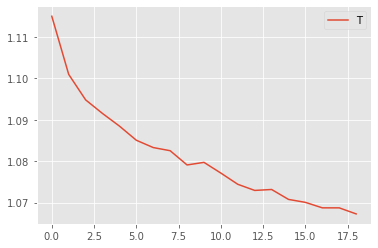

In [68]:
start = 1
plt.plot(train_loss_values[start:])
plt.legend('Train loss')

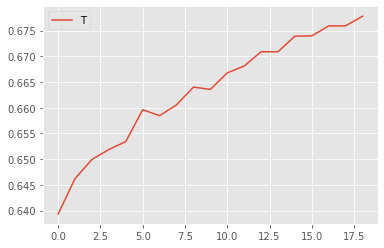

In [69]:
start = 1
plt.plot(train_accuracy_values[start:])
plt.legend('Train accuracy')

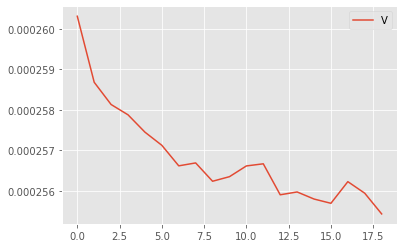

In [70]:
plt.plot(valid_loss_values[start:])
plt.legend('Validation loss')

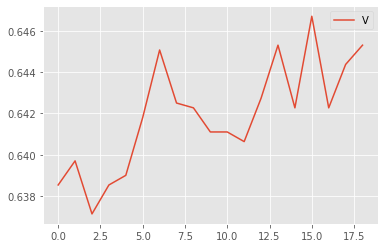

In [71]:
plt.plot(valid_accuracy[start:])
plt.legend('Validation accuracy')

Сохраним модель. Файл может иметь два расширения, как .pt, так и .pth. 

In [72]:
torch.save(model, 'simple_nn.pth')

Теперь загрузим сохраненную модель и посмотрим на ее предсказания. Важно! Когда идет этап inference модели, то нужно явно вызвать `model.eval()`, так как в случае если есть droupout или batch norm, то они не дложны работать как в процессе обучения, иначе они продолжат обучаться. 

In [73]:
model = torch.load('simple_nn.pth')
model.eval()

Sequential(
  (0): Linear(in_features=37, out_features=64, bias=True)
  (1): BatchNorm1d(64, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Linear(in_features=64, out_features=64, bias=True)
  (4): BatchNorm1d(64, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
  (5): ReLU()
  (6): Linear(in_features=64, out_features=4, bias=True)
  (7): Softmax(dim=None)
)

In [79]:
# Выход модели (вероятность) на тестовой выборке
with torch.no_grad():
    test_scores = model(torch.tensor(X_test.astype(np.float32)).to(device)).cpu()
print(accuracy(test_scores, torch.tensor(y_test.astype(np.int))).item())
print(test_scores.numpy().shape)
print(np.around(test_scores.numpy(), decimals=3))

0.6479610800743103
(5346, 4)
[[0.992 0.    0.    0.008]
 [0.985 0.004 0.007 0.004]
 [0.18  0.007 0.011 0.802]
 ...
 [0.999 0.    0.001 0.001]
 [0.691 0.011 0.007 0.291]
 [0.999 0.    0.001 0.   ]]


In [80]:
# Предсказание классов на тестовой выборке
with torch.no_grad():
    test_scores = model(torch.tensor(X_test.astype(np.float32)).to(device)).cpu()
predicted_classes = torch.argmax(test_scores, dim=1)
print(predicted_classes)

tensor([0, 0, 3,  ..., 0, 0, 0])


 Если `loss` еще падает, то точность не растет. __Как думаете, с чем это может быть связано?__

__Домашнее задание.__
Нужно обучить нейронную сеть, точность классификация должна быть не меньше __60%__. Как это можно получить:
1. Посмотрите на данные, характеристики.
2. Попробуйте менять гиперпараметры сети.
3. Обратите внимание на саму архитектуру сети.
4. Сделайте подсчет точности на валидационной выборке не через DataLoader.